In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
from skimage import io, color, transform, feature
from skimage.feature import hog
from skimage.util import img_as_ubyte
from sklearn.neural_network import MLPClassifier
from my_measures import BinaryClassificationPerformance  
from sklearn.model_selection import train_test_split
%matplotlib inline

In [59]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.03
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

In [60]:
# file paths/names

root_dir = '/Users/smolloy'

ci_path = root_dir + '/Dev/parsons/ml-2020_data/plane_data/cropped_images_18/' # file path for cropped images for training
l_file = root_dir + '/Dev/parsons/ml-2020_data/plane_data/plane_labels_2018.csv' # file path and file name for csv with labels

In [61]:
# in downscaling the image, what do you want the new dimensions to be?
# the original dimensions of cropped images: (60, 140), which if 8,400 pixels
dims = (30, 70) # random number distortion of the original size, 525 pixels

downscaled image shape: 
(2, 2)
image representation (first row of pixels): 
[126.34952038 400.07590799]


example of transformation: 


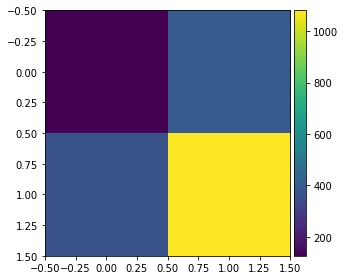

In [104]:
def image_manipulation(imname, imgs_path, imview=False):
    warnings.filterwarnings('ignore')
    
    # TRANSFORMATIONS
    imname = imgs_path + imname + '.png'
    img_raw = io.imread(imname, as_gray=True)
    downscaled = transform.resize(img_raw, (dims[0], dims[1])) # downscale image
    
    # FEATURES
    #fd, hog_image = hog(img_raw, pixels_per_cell=(5, 5), visualize=True)    
    #final_image = feature.canny(img_raw, sigma=1.0, low_threshold=0.0, high_threshold=0.5, mask=None, use_quantiles=True)
    #ip = feature.peak_local_max(img_raw, min_distance=1, exclude_border=False, indices=True)
    #final_image = feature.canny(img_raw, low_threshold=0.0, high_threshold=0.5) # edge filter image with Canny algorithm
    
    cnvt = img_as_ubyte(img_raw)
    g = feature.greycomatrix(cnvt, [1, 2], [0, np.pi/2], levels=256, symmetric=True, normed=True)
    final_image = feature.greycoprops(g,'contrast')
    
    
    if imview==True:
        io.imshow(final_image)
    warnings.filterwarnings('always')
    return final_image
    
# test the function, look at input/output
test_image = image_manipulation('2017-08-25T23+24+13_390Z', ci_path, True)
print('downscaled image shape: ')
print(test_image.shape)
print('image representation (first row of pixels): ')
print(test_image[0])
print('\n')
print('example of transformation: ')

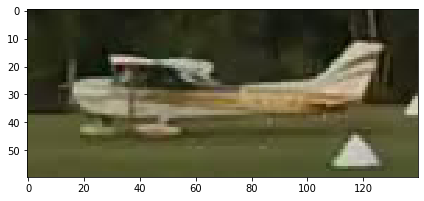

In [105]:
this_imname = ci_path + '2017-08-25T23+24+13_390Z.png'
io.imshow(io.imread(this_imname))

In [106]:
# function that takes raw images and completes all preprocessing required before model fits
def process_raw_data(labels_fn, images_fp, my_random_seed, imview=False, test=False):
    plane_data = pd.read_csv(labels_fn) # read in photograph labels
    print("First few lines of image labels: ")
    print(plane_data.head())
    print("Size of image label dataFrame: ")
    print(plane_data.shape)
        
    # construct lists for features, labels, and a crosswalk reference to image names
    features_list = []
    if (not test):
        y_list = []
    imnames_list = []

    for index, row in plane_data.iterrows():
        features_list.append(image_manipulation(row['img_name'], images_fp))
        if (not test):
            y_list.append(row['plane'])
        imnames_list.append(row['img_name'])
    
    # convert the lists to ndarrays
    features = np.asarray(features_list)
    if (not test):
        Y = np.asarray(y_list)
    imgs = np.asarray(imnames_list)
    print('Shape of original feature representation: ')
    print(features.shape)

    # flatten the images ndarray to one row per image
    features_flat = features.reshape((features.shape[0], -1))

    print('Shape of flat feature representation: ')
    print(features_flat.shape)

    if (not test):
        print('Shape of Y: ')
        print(Y.shape)

        print('Number of images with planes: ')
        print(Y.sum())
    
        # create train and test sets
        data_train, data_test, y_train, y_test, imgs_train, imgs_test = train_test_split(features_flat, 
            Y, imgs, test_size = 0.25, random_state = my_random_seed)

        print('Shape of training set: ')
        print(y_train.shape)
        print('Number of training images that contain an airplane: ')
        print(y_train.sum())

        print('Shape of test set: ')
        print(y_test.shape)
        print('Number of test images that contain an airplane: ')
        print(y_test.sum())
    
    if (test):
        X_submission_test = features_flat
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(X_submission_test, plane_data)
    else: 
        print("Shape of data_train and data_test:")
        print(data_train.shape)
        print(data_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of imgs_train and imgs_test:")
        print(imgs_train.shape)
        print(imgs_test.shape)
        print('SUCCESS!')
        return(data_train, data_test, y_train, y_test, imgs_train, imgs_test)

In [107]:
data_train, data_test, y_train, y_test, imgs_train, imgs_test = process_raw_data(l_file, ci_path, 
    my_random_seed=42, imview=False, test=False)

First few lines of image labels: 
                   img_name  plane
0  2016-08-02T13+50+24_430Z  False
1  2016-08-02T14+12+37_390Z  False
2  2016-08-02T22+20+26_600Z  False
3  2016-08-03T12+04+30_670Z  False
4  2016-08-03T12+32+21_790Z  False
Size of image label dataFrame: 
(6758, 2)
Shape of original feature representation: 
(6758, 2, 2)
Shape of flat feature representation: 
(6758, 4)
Shape of Y: 
(6758,)
Number of images with planes: 
101
Shape of training set: 
(5068,)
Number of training images that contain an airplane: 
76
Shape of test set: 
(1690,)
Number of test images that contain an airplane: 
25
Shape of data_train and data_test:
(5068, 4)
(1690, 4)
Shape of y_train and y_test:
(5068,)
(1690,)
Shape of imgs_train and imgs_test:
(5068,)
(1690,)
SUCCESS!


In [108]:
# MODEL: Perceptron
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(data_train, y_train)

# scaler = StandardScaler()  # doctest: +SKIP
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

prc_performance = BinaryClassificationPerformance(prc.predict(data_train), y_train, 'prc')
prc_performance.compute_measures()
prc_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(prc_performance.performance_measures)

prc_performance_test = BinaryClassificationPerformance(prc.predict(data_test), y_test, 'prc')
prc_performance_test.compute_measures()
prc_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(prc_performance_test.performance_measures)

prc_performance_test.img_indices()
prc_img_indices_to_view = prc_performance_test.image_indices

TRAINING SET: 
{'Pos': 76, 'Neg': 4992, 'TP': 69, 'TN': 4747, 'FP': 245, 'FN': 7, 'Accuracy': 0.9502762430939227, 'Precision': 0.2197452229299363, 'Recall': 0.9078947368421053, 'desc': 'prc', 'set': 'train'}
TEST SET: 
{'Pos': 25, 'Neg': 1665, 'TP': 24, 'TN': 1586, 'FP': 79, 'FN': 1, 'Accuracy': 0.9526627218934911, 'Precision': 0.23300970873786409, 'Recall': 0.96, 'desc': 'prc', 'set': 'test'}


In [109]:
def performance_examples(typ, measures):
    iiv = ''
    if typ == 'FP':
        iiv = typ + '_indices'
    elif typ == 'TP':
        iiv = typ + '_indices'
    elif typ == 'FN':
        iiv = typ + '_indices'
    else:
        raise ValueError('input must be "TP", "FP", or "FN"')
    for img in measures[iiv]:
        warnings.filterwarnings('ignore')    
        plt.figure()
        lookat = ci_path + imgs_test[img] + '.png' # location of original image
        io.imshow(lookat) # show original image
        plt.figure()
#io.imshow(data_test[img].reshape(dims[0], dims[1])) # show manipulation for feature representation
        warnings.filterwarnings('always')

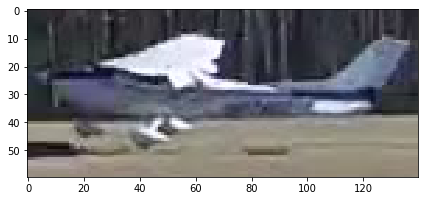

<Figure size 432x288 with 0 Axes>

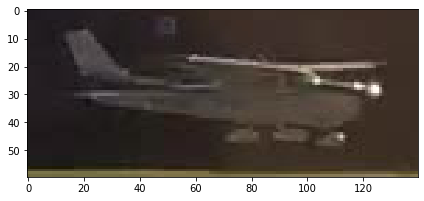

<Figure size 432x288 with 0 Axes>

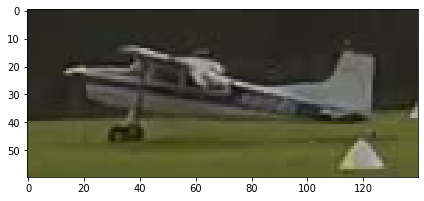

<Figure size 432x288 with 0 Axes>

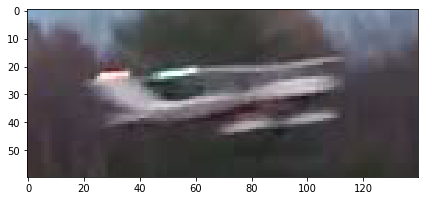

<Figure size 432x288 with 0 Axes>

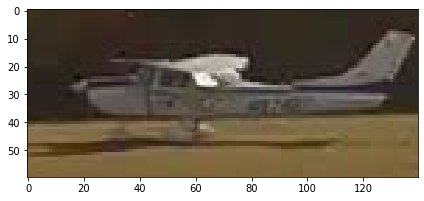

<Figure size 432x288 with 0 Axes>

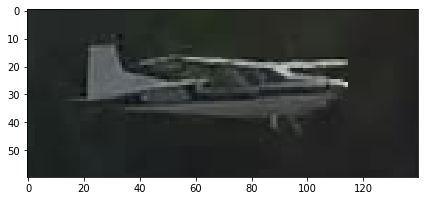

<Figure size 432x288 with 0 Axes>

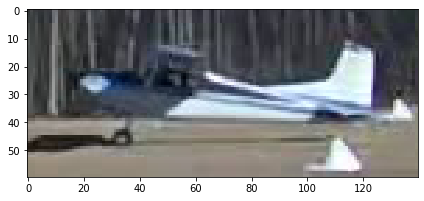

<Figure size 432x288 with 0 Axes>

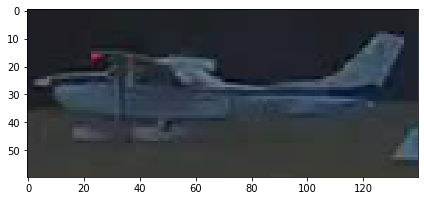

<Figure size 432x288 with 0 Axes>

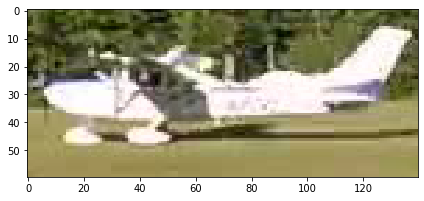

<Figure size 432x288 with 0 Axes>

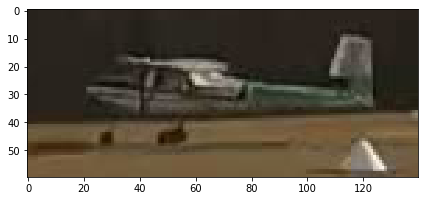

<Figure size 432x288 with 0 Axes>

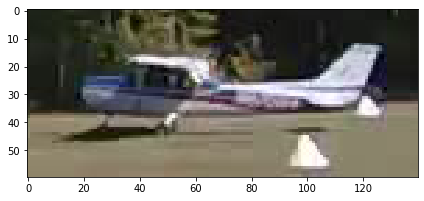

<Figure size 432x288 with 0 Axes>

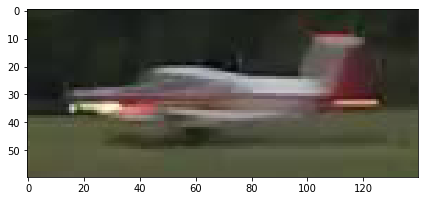

<Figure size 432x288 with 0 Axes>

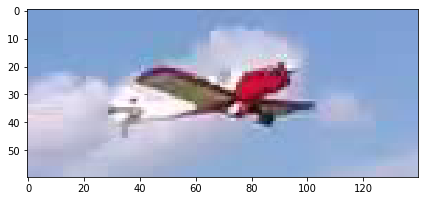

<Figure size 432x288 with 0 Axes>

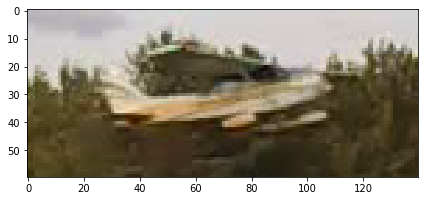

<Figure size 432x288 with 0 Axes>

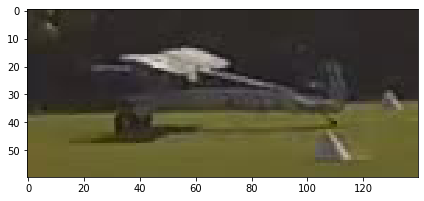

<Figure size 432x288 with 0 Axes>

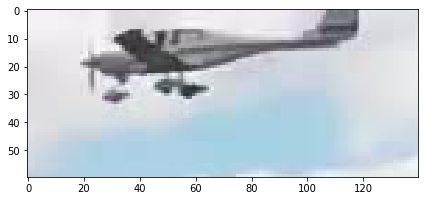

<Figure size 432x288 with 0 Axes>

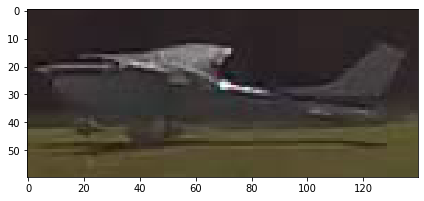

<Figure size 432x288 with 0 Axes>

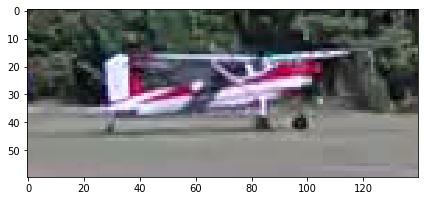

<Figure size 432x288 with 0 Axes>

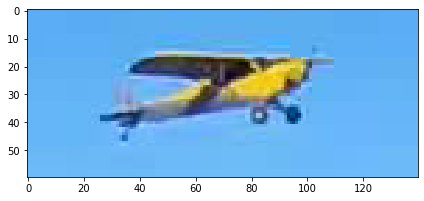

<Figure size 432x288 with 0 Axes>

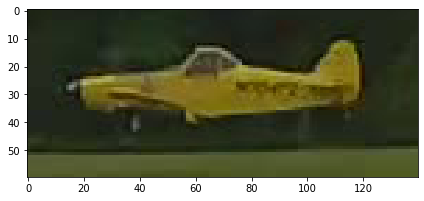

<Figure size 432x288 with 0 Axes>

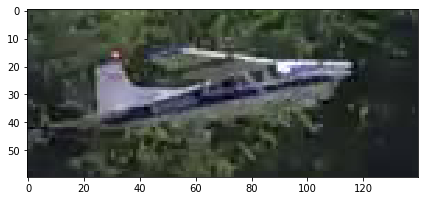

<Figure size 432x288 with 0 Axes>

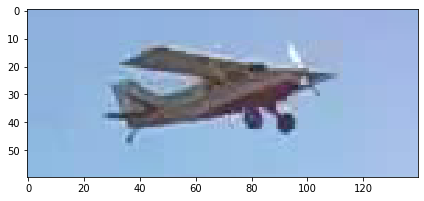

<Figure size 432x288 with 0 Axes>

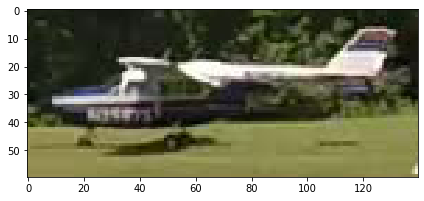

<Figure size 432x288 with 0 Axes>

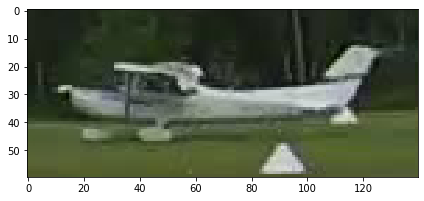

<Figure size 432x288 with 0 Axes>

In [110]:
performance_examples('TP', prc_img_indices_to_view)

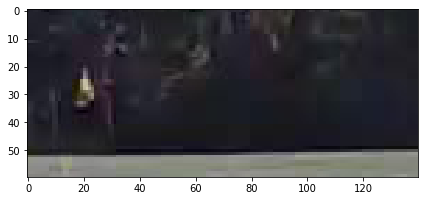

<Figure size 432x288 with 0 Axes>

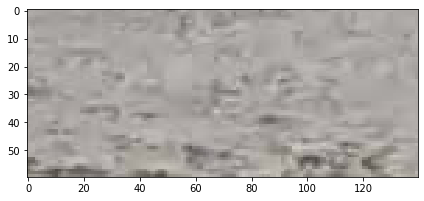

<Figure size 432x288 with 0 Axes>

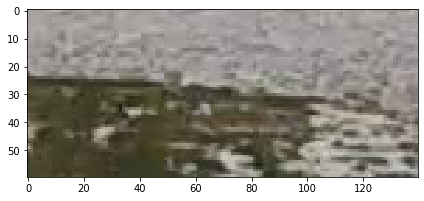

<Figure size 432x288 with 0 Axes>

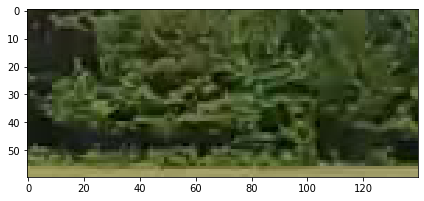

<Figure size 432x288 with 0 Axes>

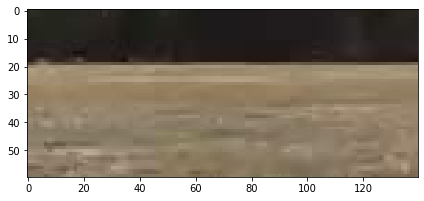

<Figure size 432x288 with 0 Axes>

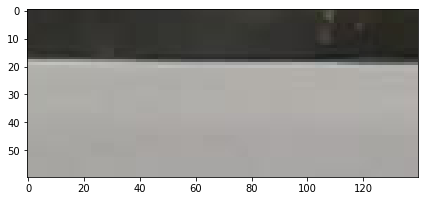

<Figure size 432x288 with 0 Axes>

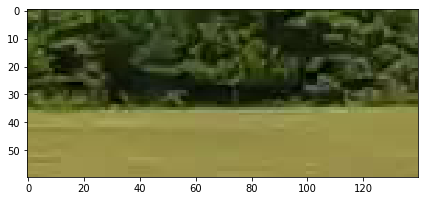

<Figure size 432x288 with 0 Axes>

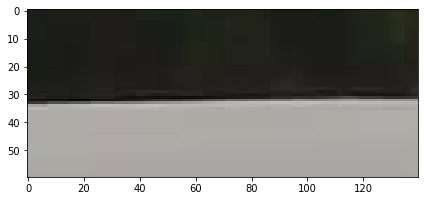

<Figure size 432x288 with 0 Axes>

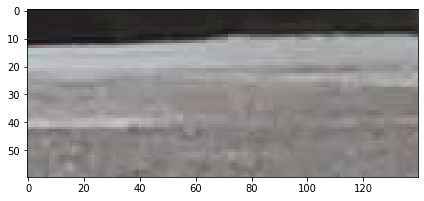

<Figure size 432x288 with 0 Axes>

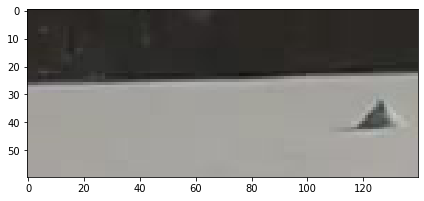

<Figure size 432x288 with 0 Axes>

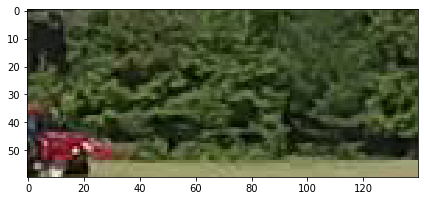

<Figure size 432x288 with 0 Axes>

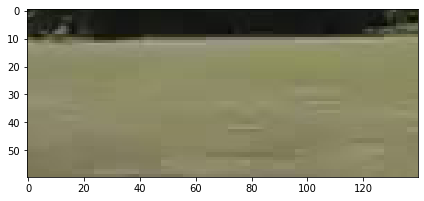

<Figure size 432x288 with 0 Axes>

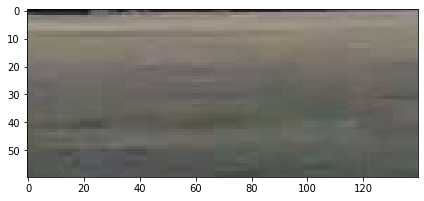

<Figure size 432x288 with 0 Axes>

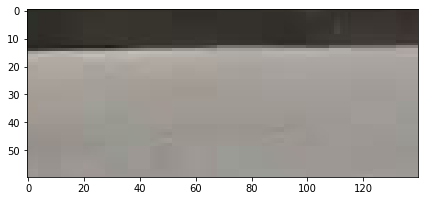

<Figure size 432x288 with 0 Axes>

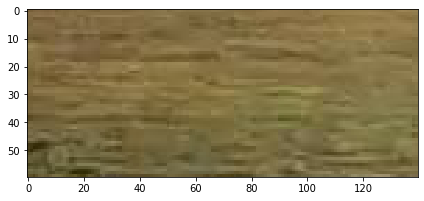

<Figure size 432x288 with 0 Axes>

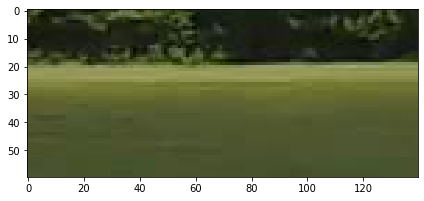

<Figure size 432x288 with 0 Axes>

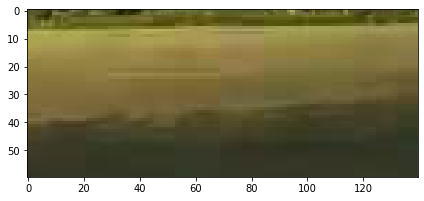

<Figure size 432x288 with 0 Axes>

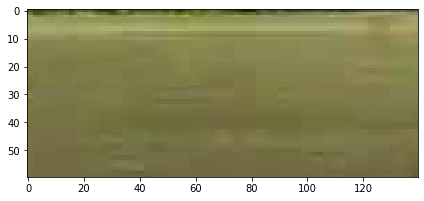

<Figure size 432x288 with 0 Axes>

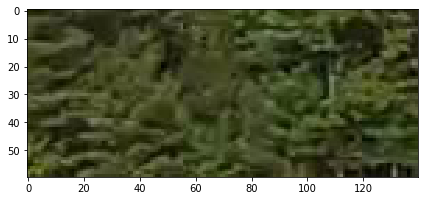

<Figure size 432x288 with 0 Axes>

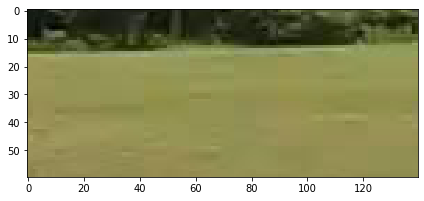

<Figure size 432x288 with 0 Axes>

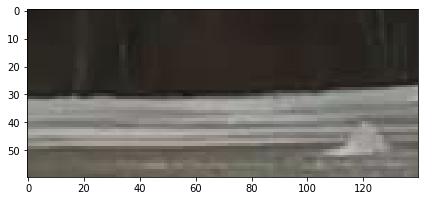

<Figure size 432x288 with 0 Axes>

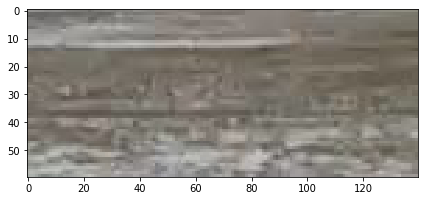

<Figure size 432x288 with 0 Axes>

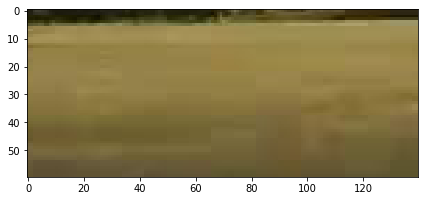

<Figure size 432x288 with 0 Axes>

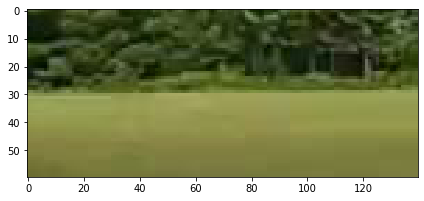

<Figure size 432x288 with 0 Axes>

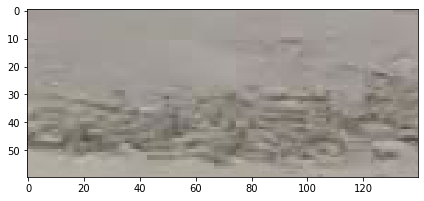

<Figure size 432x288 with 0 Axes>

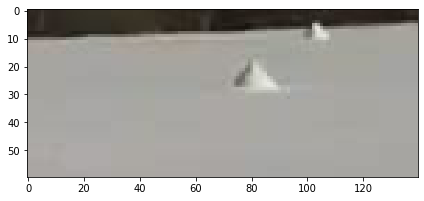

<Figure size 432x288 with 0 Axes>

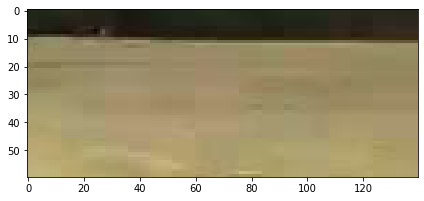

<Figure size 432x288 with 0 Axes>

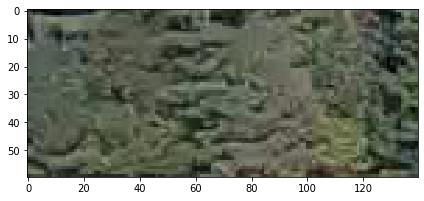

<Figure size 432x288 with 0 Axes>

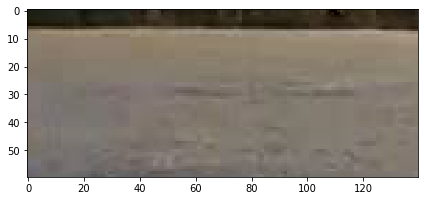

<Figure size 432x288 with 0 Axes>

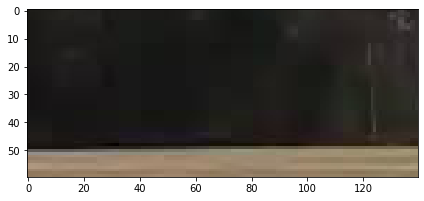

<Figure size 432x288 with 0 Axes>

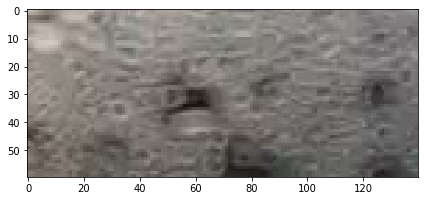

<Figure size 432x288 with 0 Axes>

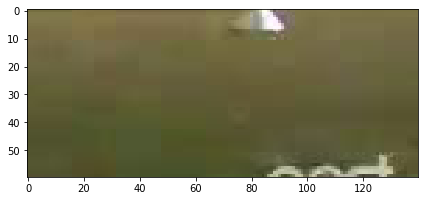

<Figure size 432x288 with 0 Axes>

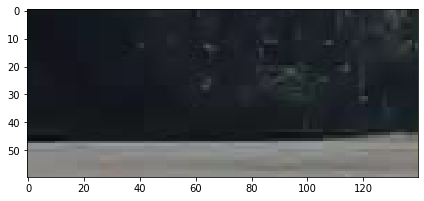

<Figure size 432x288 with 0 Axes>

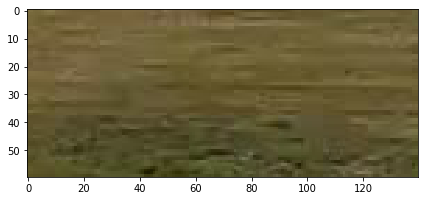

<Figure size 432x288 with 0 Axes>

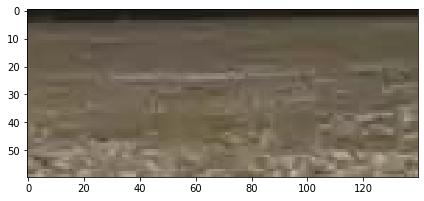

<Figure size 432x288 with 0 Axes>

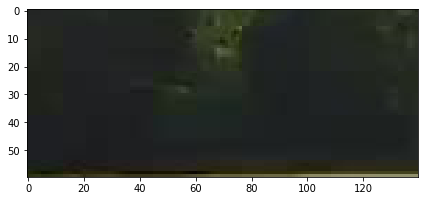

<Figure size 432x288 with 0 Axes>

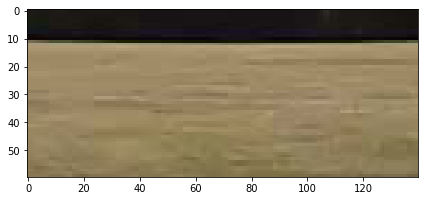

<Figure size 432x288 with 0 Axes>

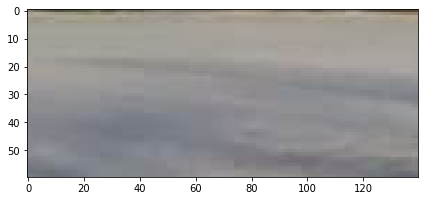

<Figure size 432x288 with 0 Axes>

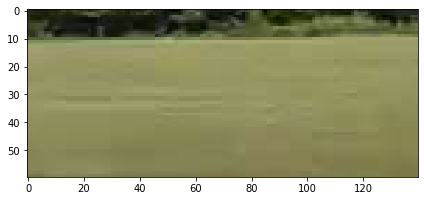

<Figure size 432x288 with 0 Axes>

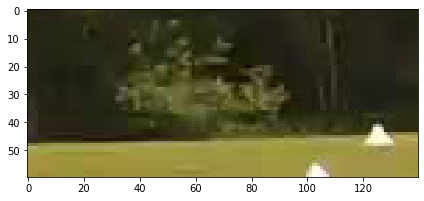

<Figure size 432x288 with 0 Axes>

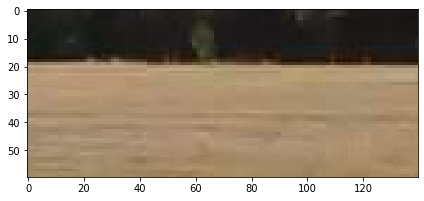

<Figure size 432x288 with 0 Axes>

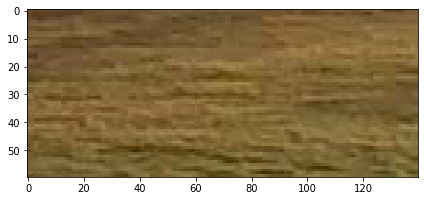

<Figure size 432x288 with 0 Axes>

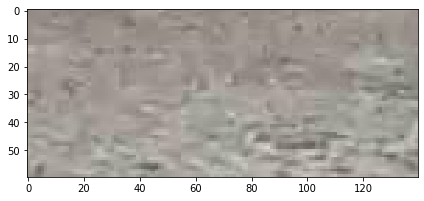

<Figure size 432x288 with 0 Axes>

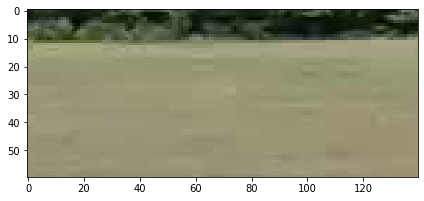

<Figure size 432x288 with 0 Axes>

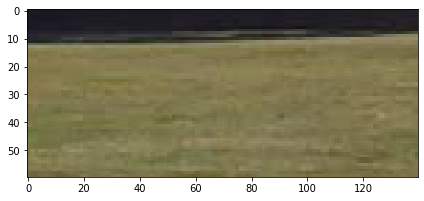

<Figure size 432x288 with 0 Axes>

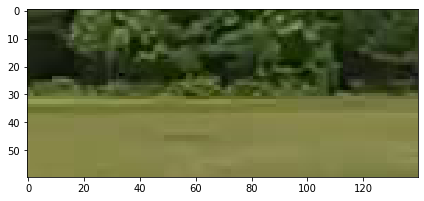

<Figure size 432x288 with 0 Axes>

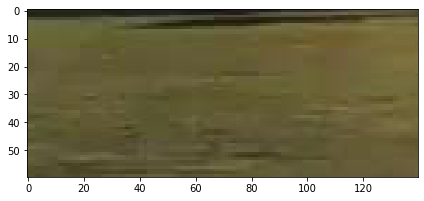

<Figure size 432x288 with 0 Axes>

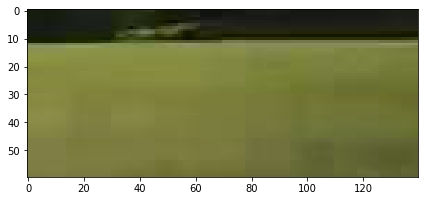

<Figure size 432x288 with 0 Axes>

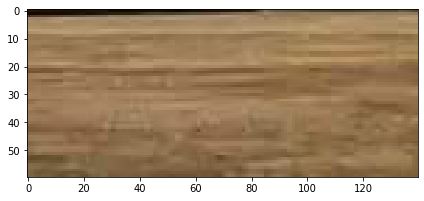

<Figure size 432x288 with 0 Axes>

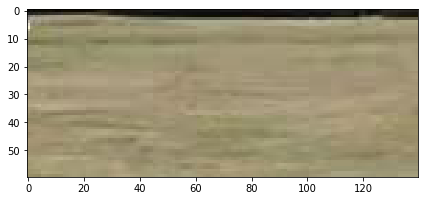

<Figure size 432x288 with 0 Axes>

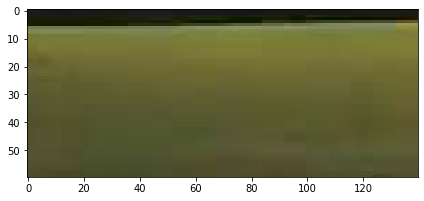

<Figure size 432x288 with 0 Axes>

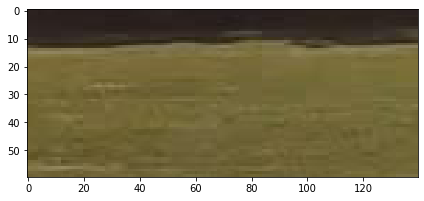

<Figure size 432x288 with 0 Axes>

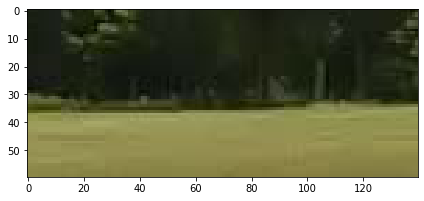

<Figure size 432x288 with 0 Axes>

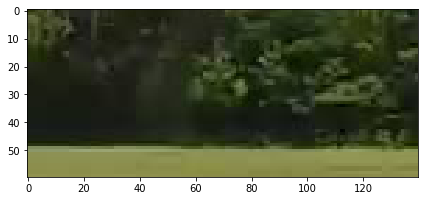

<Figure size 432x288 with 0 Axes>

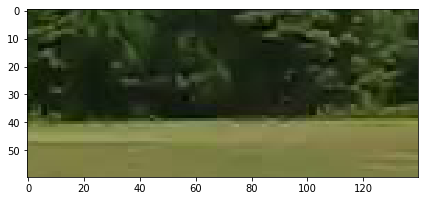

<Figure size 432x288 with 0 Axes>

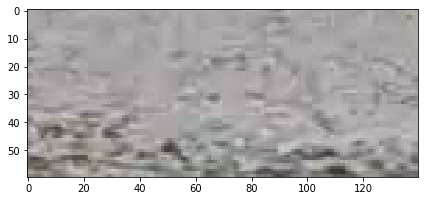

<Figure size 432x288 with 0 Axes>

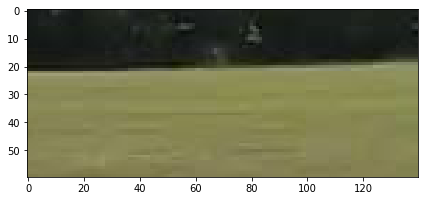

<Figure size 432x288 with 0 Axes>

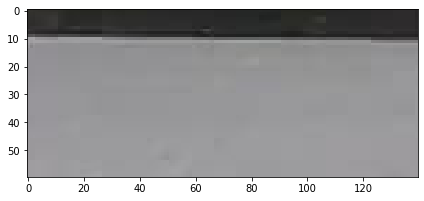

<Figure size 432x288 with 0 Axes>

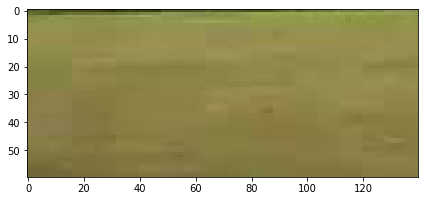

<Figure size 432x288 with 0 Axes>

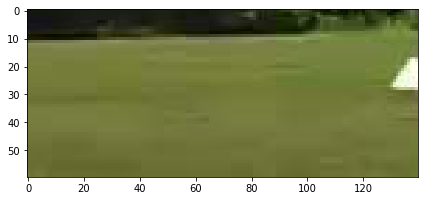

<Figure size 432x288 with 0 Axes>

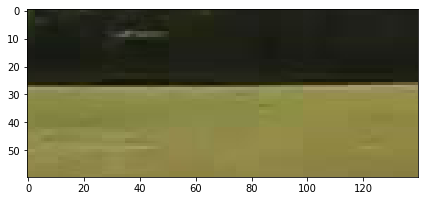

<Figure size 432x288 with 0 Axes>

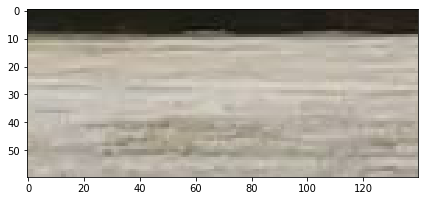

<Figure size 432x288 with 0 Axes>

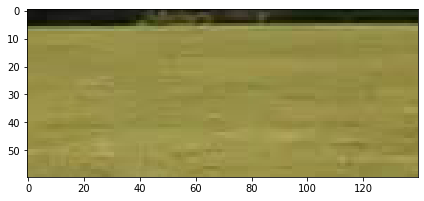

<Figure size 432x288 with 0 Axes>

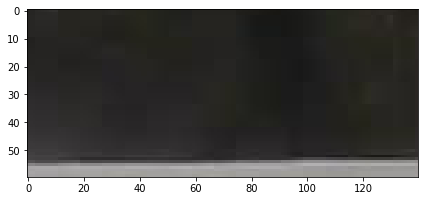

<Figure size 432x288 with 0 Axes>

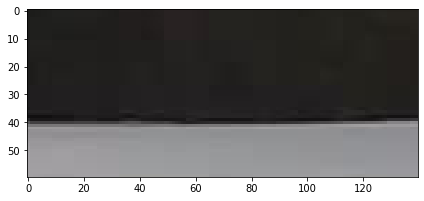

<Figure size 432x288 with 0 Axes>

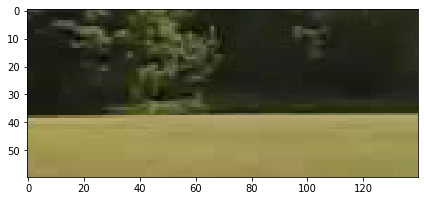

<Figure size 432x288 with 0 Axes>

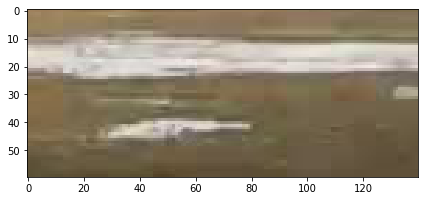

<Figure size 432x288 with 0 Axes>

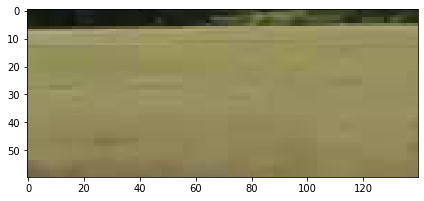

<Figure size 432x288 with 0 Axes>

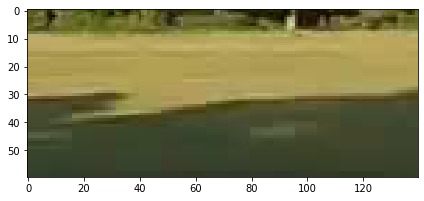

<Figure size 432x288 with 0 Axes>

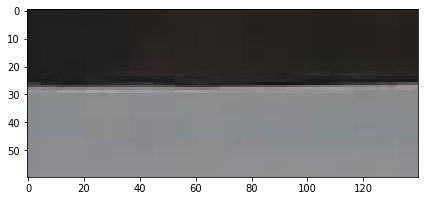

<Figure size 432x288 with 0 Axes>

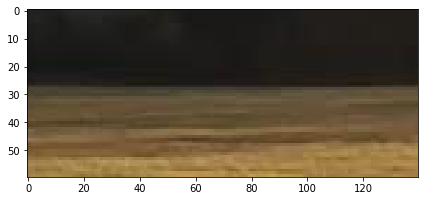

<Figure size 432x288 with 0 Axes>

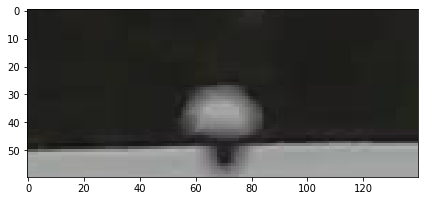

<Figure size 432x288 with 0 Axes>

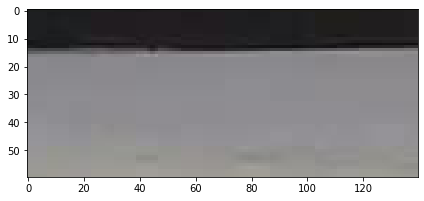

<Figure size 432x288 with 0 Axes>

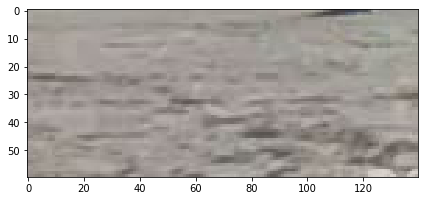

<Figure size 432x288 with 0 Axes>

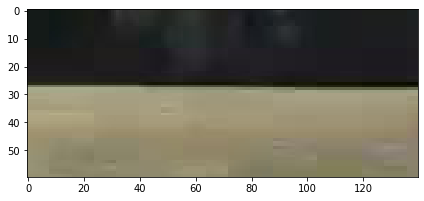

<Figure size 432x288 with 0 Axes>

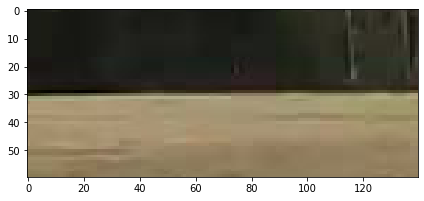

<Figure size 432x288 with 0 Axes>

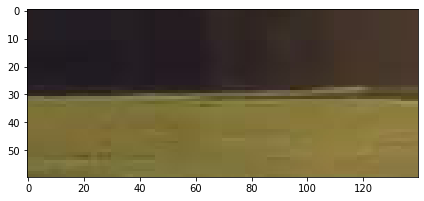

<Figure size 432x288 with 0 Axes>

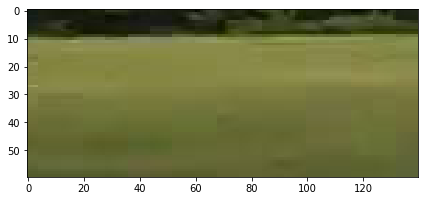

<Figure size 432x288 with 0 Axes>

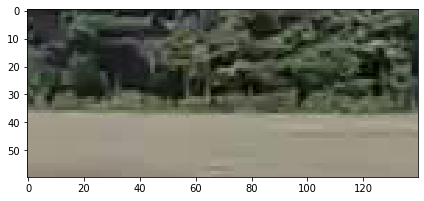

<Figure size 432x288 with 0 Axes>

In [111]:
performance_examples('FP', prc_img_indices_to_view)

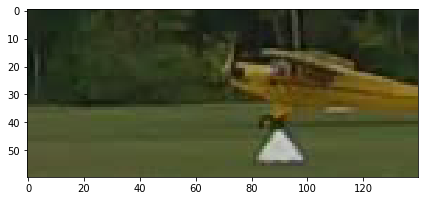

<Figure size 432x288 with 0 Axes>

In [112]:
performance_examples('FN', prc_img_indices_to_view)

In [113]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(max_iter=1000)
print(nn)
nn.fit(data_train, y_train)

nn_performance = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance.compute_measures()
nn_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance.performance_measures)

nn_performance_test = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test.compute_measures()
nn_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test.performance_measures)

nn_performance_test.img_indices()
nn_img_indices_to_view = nn_performance_test.image_indices

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
TRAINING SET: 
{'Pos': 76, 'Neg': 4992, 'TP': 72, 'TN': 4970, 'FP': 22, 'FN': 4, 'Accuracy': 0.994869771112865, 'Precision': 0.7659574468085106, 'Recall': 0.9473684210526315, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 25, 'Neg': 1665, 'TP': 18, 'TN': 1658, 'FP': 7, 'FN': 7, 'Accuracy': 0.991715976331361, 'Precision': 0.72, 'Recall': 0.72, 'desc': 'nn_test', 'set': 'test'}


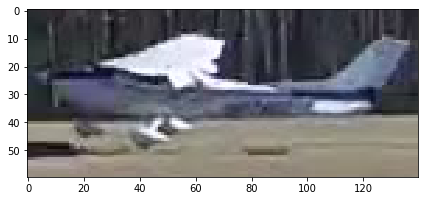

<Figure size 432x288 with 0 Axes>

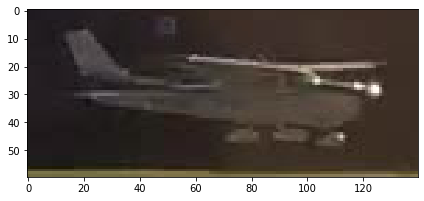

<Figure size 432x288 with 0 Axes>

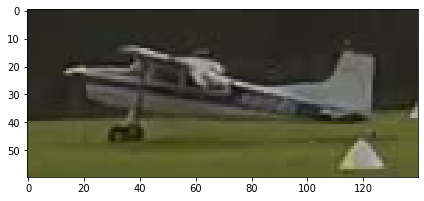

<Figure size 432x288 with 0 Axes>

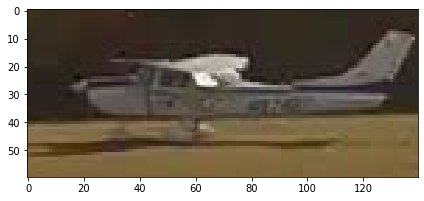

<Figure size 432x288 with 0 Axes>

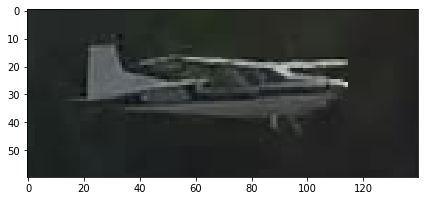

<Figure size 432x288 with 0 Axes>

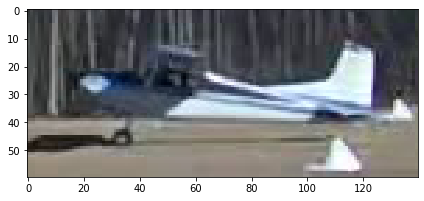

<Figure size 432x288 with 0 Axes>

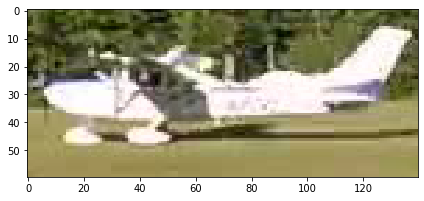

<Figure size 432x288 with 0 Axes>

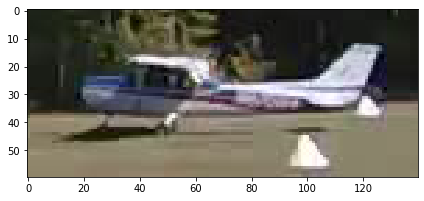

<Figure size 432x288 with 0 Axes>

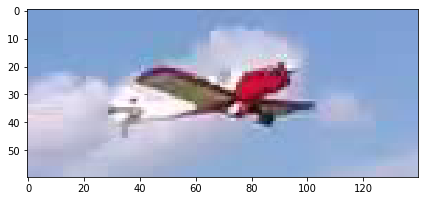

<Figure size 432x288 with 0 Axes>

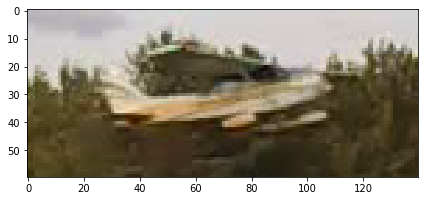

<Figure size 432x288 with 0 Axes>

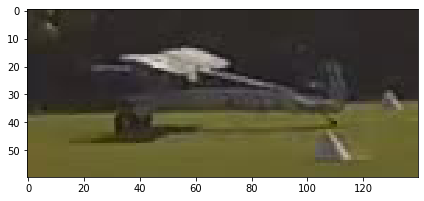

<Figure size 432x288 with 0 Axes>

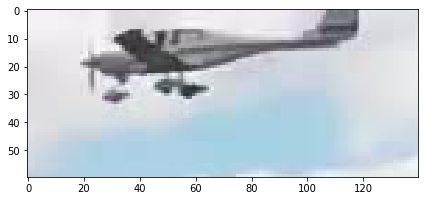

<Figure size 432x288 with 0 Axes>

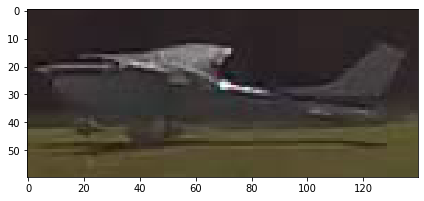

<Figure size 432x288 with 0 Axes>

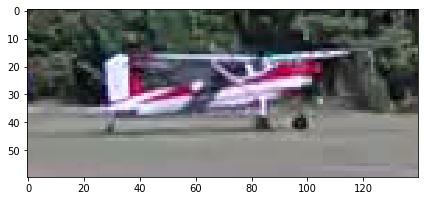

<Figure size 432x288 with 0 Axes>

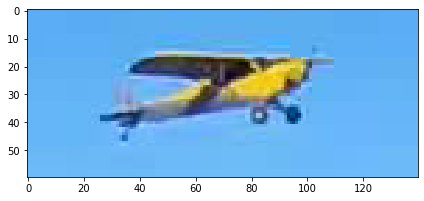

<Figure size 432x288 with 0 Axes>

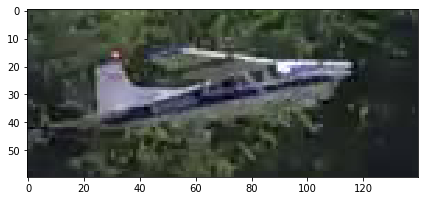

<Figure size 432x288 with 0 Axes>

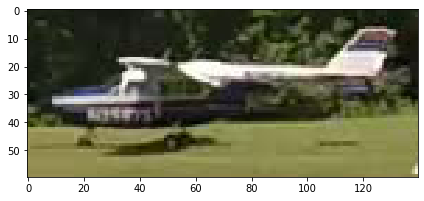

<Figure size 432x288 with 0 Axes>

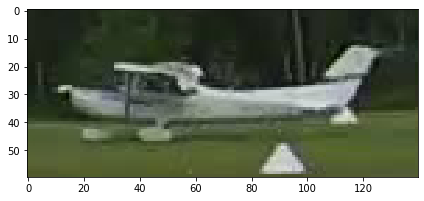

<Figure size 432x288 with 0 Axes>

In [114]:
performance_examples('TP', nn_img_indices_to_view)

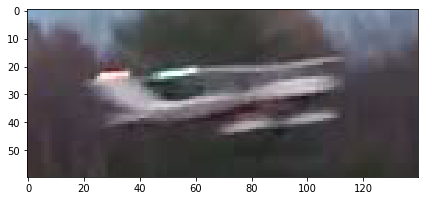

<Figure size 432x288 with 0 Axes>

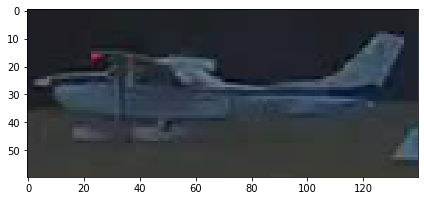

<Figure size 432x288 with 0 Axes>

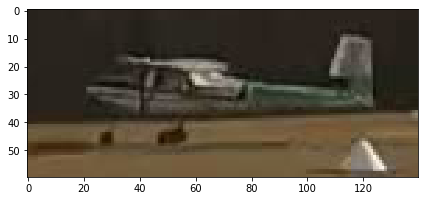

<Figure size 432x288 with 0 Axes>

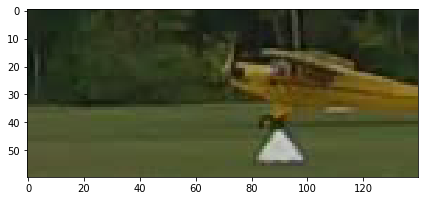

<Figure size 432x288 with 0 Axes>

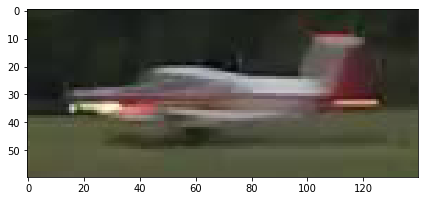

<Figure size 432x288 with 0 Axes>

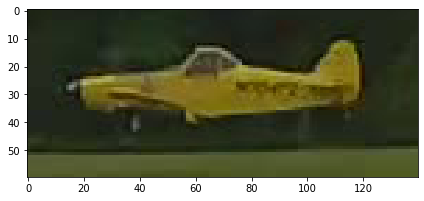

<Figure size 432x288 with 0 Axes>

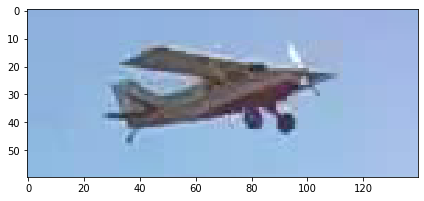

<Figure size 432x288 with 0 Axes>

In [115]:
performance_examples('FN', nn_img_indices_to_view)

In [116]:
# list of fits to compare: 
final_fits = []
final_fits.append(prc_performance.performance_measures)
final_fits.append(prc_performance_test.performance_measures)
final_fits.append(nn_performance.performance_measures)
final_fits.append(nn_performance_test.performance_measures)

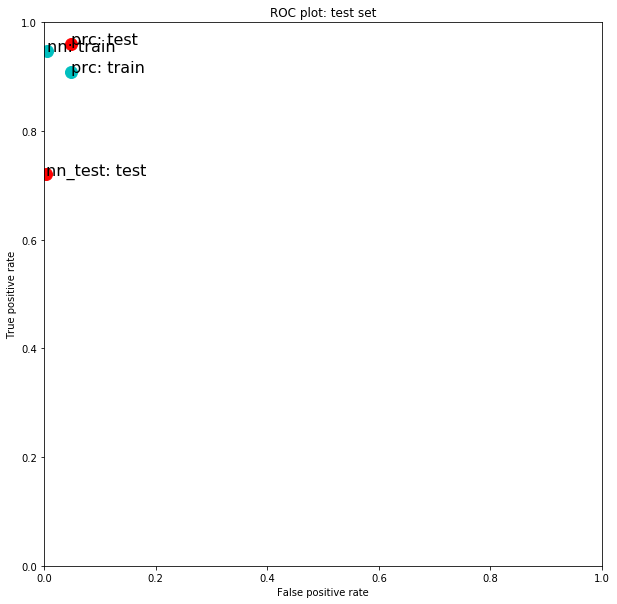

In [117]:
plt.figure(figsize=(10,10))

for fit in final_fits:
    if fit['set'] == 'train':
        color = 'co'
    else:
        color = 'ro'
    plt.plot(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], color, markersize=12)
    plt.text(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], fit['desc'] + ': ' + fit['set'], fontsize=16)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [129]:
#SUBMISSION
submission_ci_path = 'test_data_for_grading/test_cropped_images/' # file path for cropped images for training
submission_l_file = 'test_data_for_grading/test_plane_labels.csv' # file path and file name for csv with labels

In [130]:
X_test_data, X_test_submission = process_raw_data(submission_l_file, submission_ci_path, my_random_seed=42, test=True)
print("Number of rows in the submission test set (should be 1,523): ")

FileNotFoundError: [Errno 2] File b'test_data_for_grading/test_plane_labels.csv' does not exist: b'test_data_for_grading/test_plane_labels.csv'